In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
import itertools
import warnings
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

In [2]:

df_lagged = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\df_lagged.csv")
display(df_lagged.head(3))

,Periode,thuis opladen,elektrische auto,hybride elektrisch,Bijtelling (%),Consumentenvertrouwen,Economisch klimaat,Koopbereidheid,Grote aankopen,BenzineEuro95_1_first,...,TVV_Lag1,TVV_Lag2,TVV_Lag3,TVV_Lag4,TVV_Lag5,TVV_Lag6,year,month,quarter,Totaal_verkochte_wegvoertuigen
0,2007-07-01,0,1,0,22,14.0,22.0,9.0,6.2,1.451,...,112.0,84.0,62.0,123.0,39.0,31.0,2007,7,3,124
1,2007-08-01,0,1,0,22,12.0,17.0,9.0,5.6,1.415,...,124.0,112.0,84.0,62.0,123.0,39.0,2007,8,3,96
2,2007-09-01,0,1,0,22,10.0,12.0,9.0,5.0,1.422,...,96.0,124.0,112.0,84.0,62.0,123.0,2007,9,3,120


In [16]:
# Define lag and time features to add to all subsets
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Redefine feature sets with those always included
feature_sets = {
    ' (Lag Only)': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtelling (%)'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Add full feature set: everything except target and 'Periode'
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

feature_sets['All Features'] = all_features

## split

Rolling Forecast Linear Regression (horizon=3):
MAE:  2889.19
RMSE: 3766.25
R²:   0.5909
MAPE: 13.05%


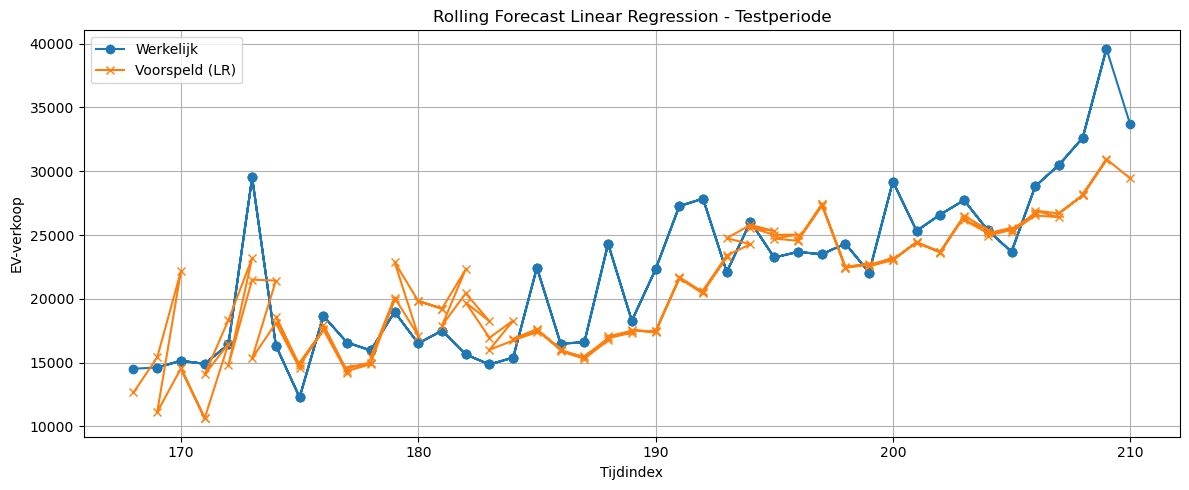

In [49]:
from sklearn.linear_model import LinearRegression

lr_result = rolling_forecast_with_val(
    df=df_lagged,
    features=baseline_features,
    target_col='Totaal_verkochte_wegvoertuigen',
    model_fn=lambda: LinearRegression(),
    horizon=3
)




XGBoost baseline (zelfde lagged features)

In [50]:
from xgboost import XGBRegressor

xgb_result = rolling_forecast_with_val(
    df=df_lagged,
    features=baseline_features,
    target_col='Totaal_verkochte_wegvoertuigen',
    model_fn=lambda: XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        verbosity=0
    ),
    horizon=3
)


Arima baseline (met rolling forecast)

In [51]:
import statsmodels.api as sm

def walkforward_arima(df, target_col, horizon=3, train_fraction=0.8):
    y = df[target_col].values
    n = len(y)
    train_size = int(n * train_fraction)

    predictions = []
    actuals = []
    indices = []

    for i in range(train_size, n - horizon + 1):
        train_series = y[:i]
        model = sm.tsa.ARIMA(train_series, order=(3, 1, 0))  # pas (p,d,q) aan indien nodig
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=horizon)
        
        y_true = y[i:i + horizon]
        predictions.extend(forecast)
        actuals.extend(y_true)
        indices.extend(range(i, i + horizon))

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mape': mape,
        'predictions': predictions,
        'actuals': actuals,
        'indices': indices
    }


In [52]:
arima_result = walkforward_arima(
    df=df_lagged,
    target_col='Totaal_verkochte_wegvoertuigen',
    horizon=3
)


In [53]:
for name, result in {
    'Linear Regression': lr_result,
    'XGBoost': xgb_result,
    'ARIMA': arima_result
}.items():
    print(f"\n{name}:")
    print(f"MAE:  {result['mae']:.2f}")
    print(f"RMSE: {result['rmse']:.2f}")
    print(f"R²:   {result['r2']:.4f}")
    print(f"MAPE: {result['mape']:.2f}%")



Linear Regression:
MAE:  2889.19
RMSE: 3766.25
R²:   0.5909
MAPE: 13.05%

XGBoost:
MAE:  7659.54
RMSE: 8968.86
R²:   -1.3202
MAPE: 33.19%

ARIMA:
MAE:  2946.30
RMSE: 4198.87
R²:   0.4915
MAPE: 12.82%


#### Full features

In [54]:
full_features = feature_sets['All Features']


Linear Regression met alle features

In [55]:
lr_full = rolling_forecast_with_val(
    df=df_lagged,
    features=full_features,
    target_col='Totaal_verkochte_wegvoertuigen',
    model_fn=lambda: LinearRegression(),
    horizon=3
)


 XGBoost met alle feature

In [56]:
xgb_full = rolling_forecast_with_val(
    df=df_lagged,
    features=full_features,
    target_col='Totaal_verkochte_wegvoertuigen',
    model_fn=lambda: XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42,
        verbosity=0
    ),
    horizon=3
)


Arimax

In [57]:
def walkforward_arimax(df, exog_features, target_col, horizon=3, train_fraction=0.8):
    y = df[target_col].values
    X = df[exog_features].values
    n = len(df)
    train_size = int(n * train_fraction)

    predictions = []
    actuals = []
    indices = []

    for i in range(train_size, n - horizon + 1):
        y_train = y[:i]
        X_train = X[:i]
        X_forecast = X[i:i+horizon]

        model = sm.tsa.SARIMAX(endog=y_train, exog=X_train, order=(3,1,0), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        forecast = model_fit.forecast(steps=horizon, exog=X_forecast)

        y_true = y[i:i+horizon]
        predictions.extend(forecast)
        actuals.extend(y_true)
        indices.extend(range(i, i+horizon))

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mape': mape,
        'predictions': predictions,
        'actuals': actuals,
        'indices': indices
    }


In [58]:
arimax_full = walkforward_arimax(
    df=df_lagged,
    exog_features=full_features,
    target_col='Totaal_verkochte_wegvoertuigen',
    horizon=3
)


c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\dylan\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

In [59]:
for name, result in {
    'Linear Regression (All)': lr_full,
    'XGBoost (All)': xgb_full,
    'ARIMAX (All)': arimax_full
}.items():
    print(f"\n{name}:")
    print(f"MAE:  {result['mae']:.2f}")
    print(f"RMSE: {result['rmse']:.2f}")
    print(f"R²:   {result['r2']:.4f}")
    print(f"MAPE: {result['mape']:.2f}%")



Linear Regression (All):
MAE:  5818.11
RMSE: 6977.35
R²:   -0.4042
MAPE: 25.78%

XGBoost (All):
MAE:  7644.33
RMSE: 8911.97
R²:   -1.2909
MAPE: 33.22%

ARIMAX (All):
MAE:  3522.40
RMSE: 5195.38
R²:   0.2214
MAPE: 15.72%
